In [75]:
import pandas as pd
import re
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
#Global Variables
Lib_Name = 'New_filter_order_Tile_ONLY_All3_bcs_TL4_i35_S1_adbc_vs hawkbc_9_4_2025' #UPDATE with library name or base name you want for your files
Fig_Format = 'jpeg' #UPDATE default graph file format

fastq_file_path = 'Staller_Tl4s1_MVS_0035_I1TTGTCACCAA_CGCACGAACA_S326.fastq.gz.assembled.fastq'#UPDATE with file path to your paired seq reads (fastq)


Output_Directory = f'{Lib_Name}_Maps_and_Graphs'
os.makedirs(Output_Directory, exist_ok=True)

#create summary tabble
summary_dict = {'Category': [], 'Read Count': []}

In [77]:
design_file_txt = 'DNA_Tiles_nkx2_2_with_primer_extensions.txt'#UPDATE with design file containing your designed tiles as a txt file

def find_designed(des):
    """Creates a lookup dictionary of all designed tiles from a file."""
    dt = []
    with open(des, 'r') as f_des:
        for line in f_des:
            # Remove the left primer
            left_trimmed = line.replace("CCCAGCTTAAGCCACCATG", "")
            
            # Remove everything after (and including) the right sequence
            right_trimmed = left_trimmed.split("GGATCCGAGCTCG")[0]
            
            dt.append(right_trimmed.strip())
    return {tile: 1 for tile in dt}


In [78]:
import re
import pandas as pd

def getmid(seq, pre, post):
    """Extracts the sequence between pre and post substrings."""
    match = re.search(f"{pre}(.*){post}", seq)
    return match.group(1) if match else "X"

def tilebc_mapper(readfile, dtd, t_len=6, bc1_len=9, rtbc_len=16, designed_len=162,
                  tile_pre="CTCGAGATAACTTCGTATAATGTATGCTAT", tile_post="GGCCGGCCATAGGGCCCC",
                  bc1_pre="GAGCTCGCTAGC", bc1_post="CTCGAGATAA",
                  rtbc_pre="GGCCGGCCATAGGGCCCC", rtbc_post="GCGGTCCA",
                  designed_pre="CACCATG", designed_post="GGATCCG"): #CHANGED POST TO JUST BE AD LENGTH
    """Processes input sequences to map tiles, HawkBCs, RTBCs, and Designed sequences."""

    # Lists to store extracted data
    tile_list, tile_lengths, tq_list = [], [], []
    bc1_list, bc1_lengths, bc1q_list = [], [], []
    rtbc_list, rtbc_lengths, rtbcq_list = [], [], []
    designed_list, designed_lengths, designedq_list = [], [], []
    sequences = []
    total_sequences = 0

    with open(readfile, 'r') as fin:
        for line in fin:
            if line.startswith('@'):
                seq = next(fin).strip()
                sequences.append(seq)
                total_sequences += 1

                # Extract Tile
                tile = getmid(seq, tile_pre, tile_post)
                tile_len = len(tile)
                tile_quality = 1 if tile_len == t_len else 0

                # Extract HawkBC
                adBC = getmid(seq, bc1_pre, bc1_post)
                adBC_len = len(adBC)
                adBC_quality = 1 if adBC_len == bc1_len else 0

                # Extract RTBC
                rtbc = getmid(seq, rtbc_pre, rtbc_post)
                rtbc_len_actual = len(rtbc)
                rtbc_quality = 1 if rtbc_len_actual == rtbc_len else 0

                # Extract Designed
                designed = getmid(seq, designed_pre, designed_post)
                designed_len_actual = len(designed)
                designed_quality = 1 if designed in dtd else 0

                # Store all values
                tile_list.append(tile)
                tile_lengths.append(tile_len)
                tq_list.append(tile_quality)

                bc1_list.append(adBC)
                bc1_lengths.append(adBC_len)
                bc1q_list.append(adBC_quality)

                rtbc_list.append(rtbc)
                rtbc_lengths.append(rtbc_len_actual)
                rtbcq_list.append(rtbc_quality)

                designed_list.append(designed)
                designed_lengths.append(designed_len_actual)
                designedq_list.append(designed_quality)

    # Create DataFrame
    tileBC_df = pd.DataFrame({
        "Reads": sequences,
        "ADBC2": tile_list,
        "ADBC2 Len": tile_lengths,
        "ADBC2 Qual": tq_list,
        "HawkBCs": bc1_list,
        "HawkBC Len": bc1_lengths,
        "HawkBC Qual": bc1q_list,
        "RTBC": rtbc_list,
        "RTBC Len": rtbc_lengths,
        "RTBC Qual": rtbcq_list,
        "Designed": designed_list,
        "Designed Len": designed_lengths,
        "Designed Qual": designedq_list
    })

    return tileBC_df



In [79]:
def process_maps(input_file, design_file):
    designed_tile_dict = find_designed(design_file)
    map1 = tilebc_mapper(input_file, designed_tile_dict)
    return map1, designed_tile_dict

In [80]:
map1, designed_tile_dict = process_maps(fastq_file_path, design_file_txt)

### Output df has all reads from the seqfile

map1 is the original df

In [81]:
#export the Map1 LUT
map1.to_csv(os.path.join(Output_Directory, f'{Lib_Name}_map1.csv'), index=False)

In [82]:
map1

Reads   ADBC2  ADBC2 Len  \
0      CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...       X          1   
1      CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...       X          1   
2      ACTACCCAGCTTAAGCCACCATGACCGACTTCATCGACGAGGAGGT...       X          1   
3      ACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACCTT...       X          1   
4      TACCCAGCTTAAGCCACCATGACCGCCTTCATCGCCGCCGCCGTGC...       X          1   
...                                                  ...     ...        ...   
77530  TACCCAGCTTAAGCCACCATGGACTCTCCCGGACCCGGCGCCACAC...  GGGCGA          6   
77531  ACCCAGCTTAAGCCACCATGACCTTCAGCGACCTGTGGAAGCTGCT...  TGATCC          6   
77532  ACCCAGCTTAAGCCACCATGGTCCAGGACGCCGCCGCCGCCACCGC...  TATATC          6   
77533  CTACCCAGCTTAAGCCACCATGGCCCAGGACCTGGCCGCCGCCACC...  TGAACC          6   
77534  CTACCCAGCTTAAGCCACCATGTTCGCCGACGCCACCCAGGCCGCC...  ACTAAC          6   

       ADBC2 Qual    HawkBCs  HawkBC Len  HawkBC Qual              RTBC  \
0               0          X           1            0                 X   
1               0  ACCAAGATC           9            1                 X   
2               0          X           1            0                 X   
3               0          X           1            0                 X   
4               0          X           1            0                 X   
...           ...        ...         ...          ...               ...   
77530           1  CCATCGACA           9            1  TAGCTAGAGTAAATTT   
77531           1  CCGTGTTGT           9            1  TGGTACGTAAATCTAC   
77532           1  ATAGCACAC           9            1  ATCTGACTACGCGGTA   
77533           1  ATCAGGACC           9            1  ACATATAAAAAGATAT   
77534           1  AACGTCACT           9            1  GTGTAACACATTCTAG   

       RTBC Len  RTBC Qual                                           Designed  \
0             1          0                                                  X   
1             1          0  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
2             1          0                                                  X   
3             1          0                                                  X   
4             1          0                                                  X   
...         ...        ...                                                ...   
77530        16          1  GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...   
77531        16          1  ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...   
77532        16          1  GTCCAGGACGCCGCCGCCGCCACCGCCCAGGCCGGCATTCCCGCCA...   
77533        16          1  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...   
77534        16          1  TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...   

       Designed Len  Designed Qual  
0                 1              0  
1               162              0  
2                 1              0  
3                 1              0  
4                 1              0  
...             ...            ...  
77530           162              1  
77531           162              1  
77532           162              0  
77533           162              1  
77534           162              1  

[77535 rows x 13 columns]

In [83]:
#below are seires of analysis on the loook up table that was created 

In [84]:
#count reads with correct tile length, BC lenngth, and are in designed file
count_rows_t = ((map1['ADBC2 Qual'] == 1)).sum()

summary_dict['Category'].append(f'Reads with Correct ADBC2 Length')
summary_dict['Read Count'].append(count_rows_t)

print("Number of rows with 1 in ADBC2 Qual :", count_rows_t)

Number of rows with 1 in ADBC2 Qual : 70240


In [85]:
#count reads with correct tile length, BC lenngth, and are in designed file
count_rows_r = ((map1['RTBC Qual'] == 1)).sum()

summary_dict['Category'].append(f'Reads with Correct RTBC Length')
summary_dict['Read Count'].append(count_rows_r)

print("Number of rows with 1 in RTBC Qual :", count_rows_r)

Number of rows with 1 in RTBC Qual : 70239


In [86]:
#count reads with correct tile length, BC lenngth, and are in designed file
count_rows_a = ((map1['HawkBC Qual'] == 1)).sum()

summary_dict['Category'].append(f'Reads with Correct HawkBC Length')
summary_dict['Read Count'].append(count_rows_a)

print("Number of rows with 1 in HawkBC Qual :", count_rows_a)

Number of rows with 1 in HawkBC Qual : 73324


In [87]:
#count reads with correct tile length, BC lenngth, and are in designed file
count_rows_one = len(map1[(map1['ADBC2 Qual'] == 1) & (map1['HawkBC Qual'] == 1)])

summary_dict['Category'].append(f'Rows with correct ADBC2 length and HawkBC length')
summary_dict['Read Count'].append(count_rows_one)

print("Number of rows with 1 in ADBC2 Qual and HawkBC Qual:", count_rows_one)

Number of rows with 1 in ADBC2 Qual and HawkBC Qual: 67843


In [88]:
#count reads with correct tile length, BC lenngth, and are in designed file
count_rows_2 = len(map1[(map1['ADBC2 Qual'] == 1) & (map1['RTBC Qual'] == 1)])

summary_dict['Category'].append(f'Rows with correct ADBC2 length and RTBC length')
summary_dict['Read Count'].append(count_rows_2)

print("Number of rows with 1 in ADBC2 Qual and HawkBC Qual:", count_rows_2)

Number of rows with 1 in ADBC2 Qual and HawkBC Qual: 68106


In [89]:
#count reads with correct tile length, BC lenngth, and are in designed file
count_rows_3 = len(map1[(map1['HawkBC Qual'] == 1) & (map1['RTBC Qual'] == 1)])

summary_dict['Category'].append(f'Rows with correct HwkBC length and RTBC length')
summary_dict['Read Count'].append(count_rows_3)

print("Number of rows with 1 in ADBC2 Qual and HawkBC Qual:", count_rows_3)

Number of rows with 1 in ADBC2 Qual and HawkBC Qual: 67215


In [90]:
#count reads with correct tile length, BC lenngth, and are in designed file
count_rows_4 = len(map1[(map1['HawkBC Qual'] == 1) & (map1['RTBC Qual'] == 1) & (map1['ADBC2 Qual'] == 1)])

summary_dict['Category'].append(f'Rows with correct HwkBC length, RTBC length, and AD BC2 length')
summary_dict['Read Count'].append(count_rows_4)

print("Number of rows with 1 in ADBC2 Qual, HawkBC Qual, and RTBC Qual:", count_rows_4)

Number of rows with 1 in ADBC2 Qual, HawkBC Qual, and RTBC Qual: 65798


In [91]:
#count reads with correct tile length, BC lenngth, and are in designed file
count_rows_5 = len(map1[(map1['HawkBC Qual'] == 1) & (map1['RTBC Qual'] == 1) & (map1['ADBC2 Qual'] == 1)& (map1['Designed Qual'] == 1)])

summary_dict['Category'].append(f'Rows with correct HwkBC length, RTBC length, AD BC2 length AND in designed')
summary_dict['Read Count'].append(count_rows_5)

print("Number of rows with 1 in ADBC2 Qual, HawkBC Qual, RTBC Qual, and Designed Qual:", count_rows_5)

Number of rows with 1 in ADBC2 Qual, HawkBC Qual, RTBC Qual, and Designed Qual: 50751


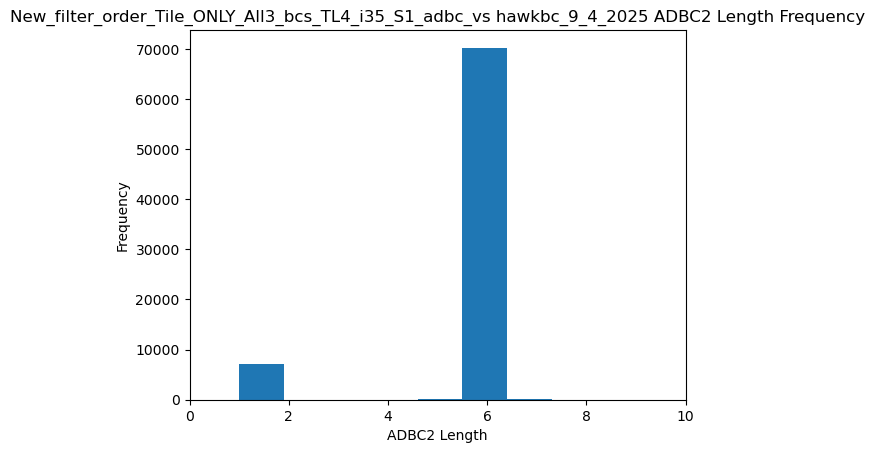

In [92]:
#plot tile length histogram
plt.hist(map1['ADBC2 Len'])
plt.xlim([0, 10]) #UPDATE if your tile length won't fit in this range
plt.title(f'{Lib_Name } ADBC2 Length Frequency')
plt.xlabel('ADBC2 Length')
plt.ylabel('Frequency')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_ADBC2_Length.{Fig_Format}'))
plt.show()


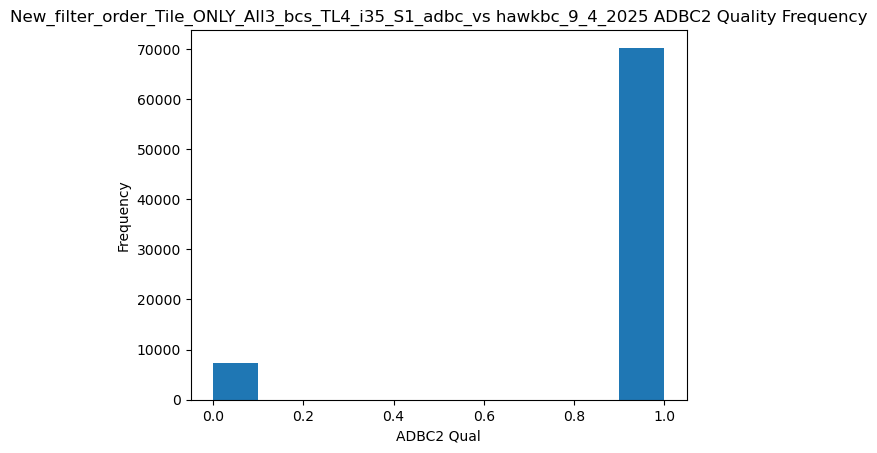

In [93]:
#plot tile qual as histogram
plt.hist(map1['ADBC2 Qual'])
plt.title(f'{Lib_Name } ADBC2 Quality Frequency')
plt.xlabel('ADBC2 Qual')
plt.ylabel('Frequency')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_ADBC2_Quality.{Fig_Format}'))
plt.show()

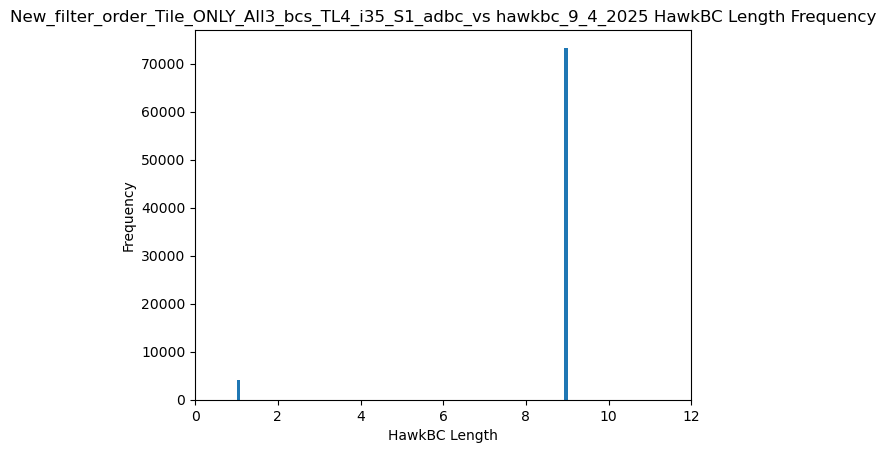

In [94]:
# plot AD BC len
plt.hist(map1['HawkBC Len'], bins=100)
plt.xlim([0, 12]) #UPDATE if your bc1 length won't fit in this range
plt.title(f'{Lib_Name } HawkBC Length Frequency')
plt.xlabel('HawkBC Length')
plt.ylabel('Frequency')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_HawkBC_length.{Fig_Format}'))
plt.show()

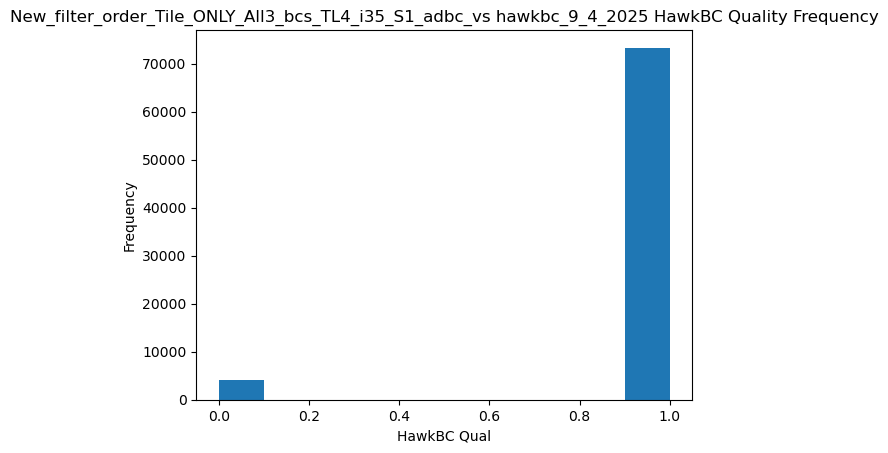

In [95]:
#plot bc1 qual as histogram

plt.hist(map1['HawkBC Qual'])
plt.title(f'{Lib_Name } HawkBC Quality Frequency')
plt.xlabel('HawkBC Qual')
plt.ylabel('Frequency')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_HawkBC_Quality.{Fig_Format}'))
plt.show()

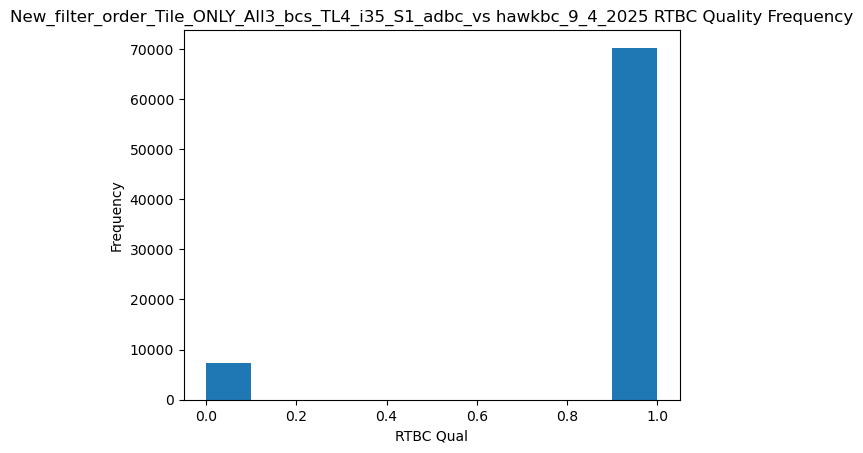

In [96]:
#plot bc1 qual as histogram

plt.hist(map1['RTBC Qual'])
plt.title(f'{Lib_Name } RTBC Quality Frequency')
plt.xlabel('RTBC Qual')
plt.ylabel('Frequency')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_RTBC_Quality.{Fig_Format}'))
plt.show()

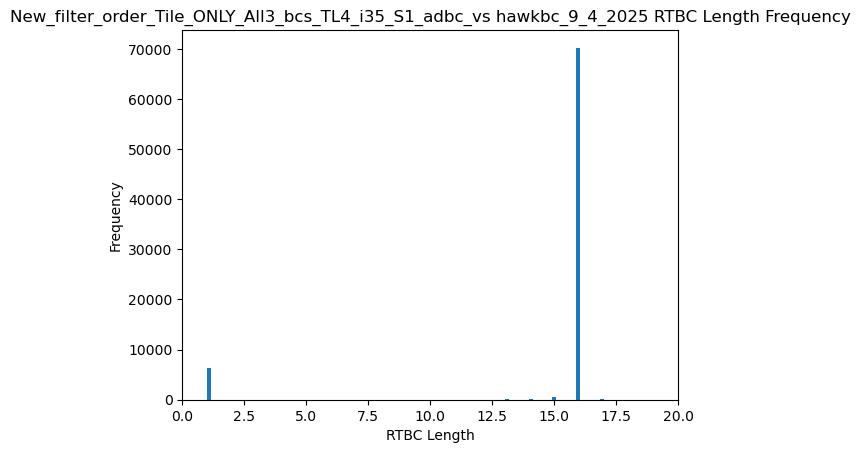

In [97]:
# plot AD BC len
plt.hist(map1['RTBC Len'], bins=100)
plt.xlim([0, 20]) #UPDATE if your bc1 length won't fit in this range
plt.title(f'{Lib_Name } RTBC Length Frequency')
plt.xlabel('RTBC Length')
plt.ylabel('Frequency')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_RTBC_length.{Fig_Format}'))
plt.show()

### Filtering out reads that either do not have the consensus sequences to find the tiles/BCs OR have tiles/BCs of unexpected lengths

map2 is the df with only tiles that match designed and where BC lengths are as expected. All length and quality columns are dropped, as well as the column that stored the full read strings.

In [98]:

#Replace all 0s in map1 with NaN to filter out any Qual=0 reads
map1_nans = map1.replace(0, np.nan)
map2 = map1_nans.dropna().reset_index()

#get rid of some now useless columns
clabels = ['index','Reads', 'ADBC2 Len','ADBC2 Qual', 'HawkBC Len','HawkBC Qual', 'RTBC Qual', 'RTBC Len', 'Designed Len', 'Designed Qual']
map2 = map2.drop(clabels, axis = 1)


# how many reads are lost? rc = readcount
rcmap1 = map1.shape[0]
rcmap2 = map2.shape[0]
diffpct = ((rcmap1 - rcmap2) / rcmap1)*100
print("% Reads lost:")
print(diffpct)

summary_dict['Category'].append(f'Map1 Shape')
summary_dict['Read Count'].append(rcmap2)

summary_dict['Category'].append(f'New Section')
summary_dict['Read Count'].append('Quality = 0 rows removed')

% Reads lost:
34.54439930354034


### Coverage
map3 is a df with tiles, BCs, and combos of tiles and BCs

In [99]:
map2

ADBC2    HawkBCs              RTBC  \
0      CGATCC  CCACATCAT  GTAAAGTAGTAAATAC   
1      ACAGAC  ACAAGCGTT  CGATAATTTAGAATGT   
2      GAATTG  AACCTACGC  TAGCGTATTGAGCGAA   
3      ACCAGA  ACATTGCCG  AGAATTTGTTCGTCTG   
4      GCTTGC  AAGGATCTG  TCTAATAGTGGATCGT   
...       ...        ...               ...   
50746  CAATCA  CCAGAAGAT  ATGAACAAGCTCGGCA   
50747  GGGCGA  CCATCGACA  TAGCTAGAGTAAATTT   
50748  TGATCC  CCGTGTTGT  TGGTACGTAAATCTAC   
50749  TGAACC  ATCAGGACC  ACATATAAAAAGATAT   
50750  ACTAAC  AACGTCACT  GTGTAACACATTCTAG   

                                                Designed  
0      AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...  
1      GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...  
2      GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...  
3      GCCCAGGACCTGGCCGCCGCCACCTTCCAGAGCAGCGGCGCCTACT...  
4      GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...  
...                                                  ...  
50746  GAGGAGCCTCAGAGCGATCCCAGCGTGGAGCCTCCTCTGAGCCAGG...  
50747  GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...  
50748  ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...  
50749  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...  
50750  TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...  

[50751 rows x 4 columns]

In [100]:
map3 = map2.copy()
map3.head()

ADBC2    HawkBCs              RTBC  \
0  CGATCC  CCACATCAT  GTAAAGTAGTAAATAC   
1  ACAGAC  ACAAGCGTT  CGATAATTTAGAATGT   
2  GAATTG  AACCTACGC  TAGCGTATTGAGCGAA   
3  ACCAGA  ACATTGCCG  AGAATTTGTTCGTCTG   
4  GCTTGC  AAGGATCTG  TCTAATAGTGGATCGT   

                                            Designed  
0  AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...  
1  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...  
2  GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...  
3  GCCCAGGACCTGGCCGCCGCCACCTTCCAGAGCAGCGGCGCCTACT...  
4  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...

In [101]:
#Add column that connects BC1 to the Tile it is paired with (Cat for concatenation) 
# Create the Cat column by concatenating HawkBCs, ADBC2, and RTBC
# Create the Cat column by concatenating HawkBCs, ADBC2, RTBC, and Designed
map3['Cat'] = map3['HawkBCs'].str.cat([map3['ADBC2'], map3['RTBC'], map3['Designed']], sep='-')
map3['HA'] = map3['HawkBCs'].str.cat([map3['ADBC2']], sep='-')
map3['HAR'] = map3['HawkBCs'].str.cat([map3['ADBC2'], map3['RTBC']], sep='-')

summary_dict['Category'].append('Map3 Shape')
summary_dict['Read Count'].append(map3.shape[0])


In [102]:
map3

ADBC2    HawkBCs              RTBC  \
0      CGATCC  CCACATCAT  GTAAAGTAGTAAATAC   
1      ACAGAC  ACAAGCGTT  CGATAATTTAGAATGT   
2      GAATTG  AACCTACGC  TAGCGTATTGAGCGAA   
3      ACCAGA  ACATTGCCG  AGAATTTGTTCGTCTG   
4      GCTTGC  AAGGATCTG  TCTAATAGTGGATCGT   
...       ...        ...               ...   
50746  CAATCA  CCAGAAGAT  ATGAACAAGCTCGGCA   
50747  GGGCGA  CCATCGACA  TAGCTAGAGTAAATTT   
50748  TGATCC  CCGTGTTGT  TGGTACGTAAATCTAC   
50749  TGAACC  ATCAGGACC  ACATATAAAAAGATAT   
50750  ACTAAC  AACGTCACT  GTGTAACACATTCTAG   

                                                Designed  \
0      AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...   
1      GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
2      GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...   
3      GCCCAGGACCTGGCCGCCGCCACCTTCCAGAGCAGCGGCGCCTACT...   
4      GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
...                                                  ...   
50746  GAGGAGCCTCAGAGCGATCCCAGCGTGGAGCCTCCTCTGAGCCAGG...   
50747  GACTCTCCCGGACCCGGCGCCACACCTCACGACAGCGCTCCCTACG...   
50748  ACCTTCAGCGACCTGTGGAAGCTGCTGCCCGAGAACAACGTGCTGT...   
50749  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...   
50750  TTCGCCGACGCCACCCAGGCCGCCCTGCAGGCCGGCATTCCCTTCA...   

                                                     Cat                HA  \
0      CCACATCAT-CGATCC-GTAAAGTAGTAAATAC-AGCATGGACGAG...  CCACATCAT-CGATCC   
1      ACAAGCGTT-ACAGAC-CGATAATTTAGAATGT-GCCCAGGACCTG...  ACAAGCGTT-ACAGAC   
2      AACCTACGC-GAATTG-TAGCGTATTGAGCGAA-GCCCAGGACCTG...  AACCTACGC-GAATTG   
3      ACATTGCCG-ACCAGA-AGAATTTGTTCGTCTG-GCCCAGGACCTG...  ACATTGCCG-ACCAGA   
4      AAGGATCTG-GCTTGC-TCTAATAGTGGATCGT-GCCCAGGACCTG...  AAGGATCTG-GCTTGC   
...                                                  ...               ...   
50746  CCAGAAGAT-CAATCA-ATGAACAAGCTCGGCA-GAGGAGCCTCAG...  CCAGAAGAT-CAATCA   
50747  CCATCGACA-GGGCGA-TAGCTAGAGTAAATTT-GACTCTCCCGGA...  CCATCGACA-GGGCGA   
50748  CCGTGTTGT-TGATCC-TGGTACGTAAATCTAC-ACCTTCAGCGAC...  CCGTGTTGT-TGATCC   
50749  ATCAGGACC-TGAACC-ACATATAAAAAGATAT-GCCCAGGACCTG...  ATCAGGACC-TGAACC   
50750  AACGTCACT-ACTAAC-GTGTAACACATTCTAG-TTCGCCGACGCC...  AACGTCACT-ACTAAC   

                                     HAR  
0      CCACATCAT-CGATCC-GTAAAGTAGTAAATAC  
1      ACAAGCGTT-ACAGAC-CGATAATTTAGAATGT  
2      AACCTACGC-GAATTG-TAGCGTATTGAGCGAA  
3      ACATTGCCG-ACCAGA-AGAATTTGTTCGTCTG  
4      AAGGATCTG-GCTTGC-TCTAATAGTGGATCGT  
...                                  ...  
50746  CCAGAAGAT-CAATCA-ATGAACAAGCTCGGCA  
50747  CCATCGACA-GGGCGA-TAGCTAGAGTAAATTT  
50748  CCGTGTTGT-TGATCC-TGGTACGTAAATCTAC  
50749  ATCAGGACC-TGAACC-ACATATAAAAAGATAT  
50750  AACGTCACT-ACTAAC-GTGTAACACATTCTAG  

[50751 rows x 7 columns]

In [103]:
#Frequency of each tile-bc combo

tbcov = map3['Cat'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique HawkBC + ADBC2 + RTBC coverage')
summary_dict['Read Count'].append(tbcov.shape[0])

print(f'number unique Hawk + ADBC2 + RTBC+ Designed Tile combos:{tbcov.shape[0]}')



number unique Hawk + ADBC2 + RTBC+ Designed Tile combos:7570


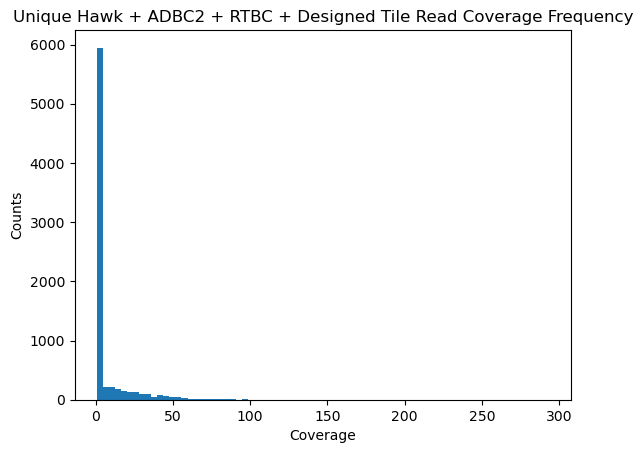

In [104]:
# plot tb coverage on histogram
plt.figure()
plt.title(f'Unique Hawk + ADBC2 + RTBC + Designed Tile Read Coverage Frequency')
plt.hist(tbcov['Cat'],  bins=75)
plt.xlabel('Coverage')
plt.ylabel('Counts')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_HAR_cov.{Fig_Format}'))
plt.show()

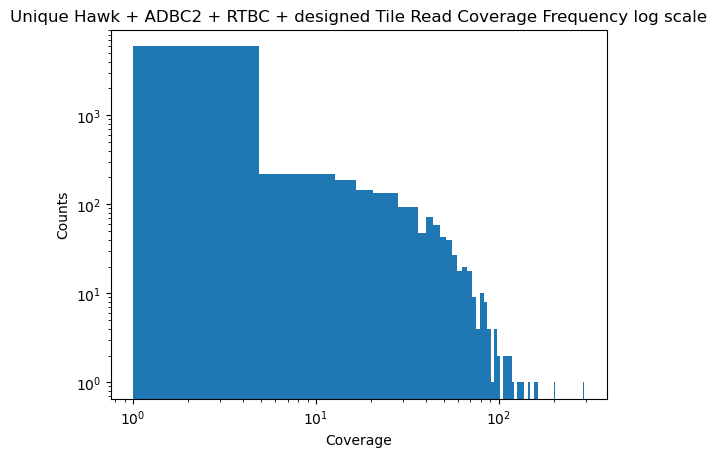

In [105]:
# plot tb coverage on histogram
plt.figure()
plt.title(f'Unique Hawk + ADBC2 + RTBC + designed Tile Read Coverage Frequency log scale')
plt.hist(tbcov['Cat'],  bins=75)
plt.xlabel('Coverage')
plt.ylabel('Counts')
plt.xscale('log')
plt.yscale('log')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_HAR_log_cov.{Fig_Format}'))
plt.show()

In [106]:
# Unique Tile coverage
tcov = map2['ADBC2'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique ADBC2 coverage')
summary_dict['Read Count'].append(tcov.shape[0])

print (f'Unique ADBCs: {tcov.shape[0]}')

Unique ADBCs: 1523


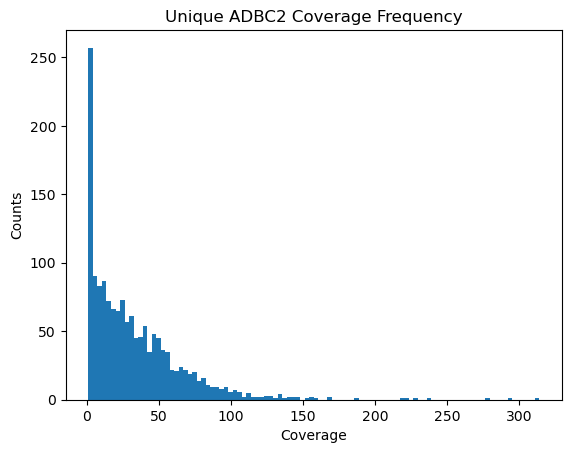

In [107]:
# plot tile coverage 
plt.hist(tcov['ADBC2'], bins=100)
plt.title(f'Unique ADBC2 Coverage Frequency')
plt.xlabel('Coverage')
plt.ylabel('Counts')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_ADBC2_cov.{Fig_Format}'))
plt.show()

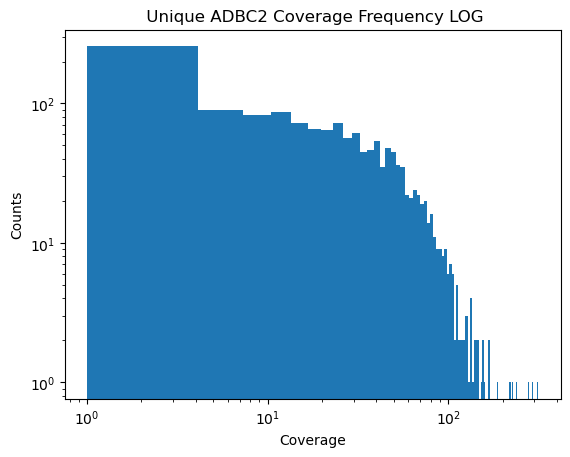

In [108]:
# plot tile coverage 
plt.hist(tcov['ADBC2'], bins=100)
plt.title(f' Unique ADBC2 Coverage Frequency LOG')
plt.xlabel('Coverage')
plt.ylabel('Counts')
plt.xscale('log')
plt.yscale('log')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_ADBC2_log_cov.{Fig_Format}'))
plt.show()

In [109]:
#Unique ad bc coverage
abcov = map3['HawkBCs'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique HawkBC')
summary_dict['Read Count'].append(abcov.shape[0])

print(f'Unique HawkBCs: {abcov.shape[0]}') # number unique ad bcs


Unique HawkBCs: 396


In [110]:
#Unique ad bc coverage
Rbcov = map3['RTBC'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique RTBC')
summary_dict['Read Count'].append(Rbcov.shape[0])

print(f'Unique RTBCs: {Rbcov.shape[0]}') # number unique ad bcs


Unique RTBCs: 3082


In [111]:
# Unique Tile coverage
tcovArd3t = map3['Designed'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Map3 Unique Tiles ')
summary_dict['Read Count'].append(tcovArd3t.shape[0])

print (f'Unique Tile Map3: {tcovArd3t.shape[0]}')

Unique Tile Map3: 233


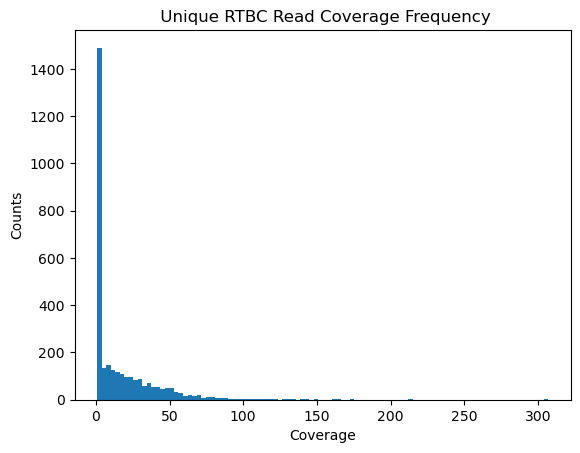

In [112]:
# plot ad bc coverage 
plt.hist(Rbcov['RTBC'], bins=100)
plt.title(f' Unique RTBC Read Coverage Frequency')
plt.xlabel('Coverage')
plt.ylabel('Counts')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_RTBC_cov.{Fig_Format}'))
plt.show()

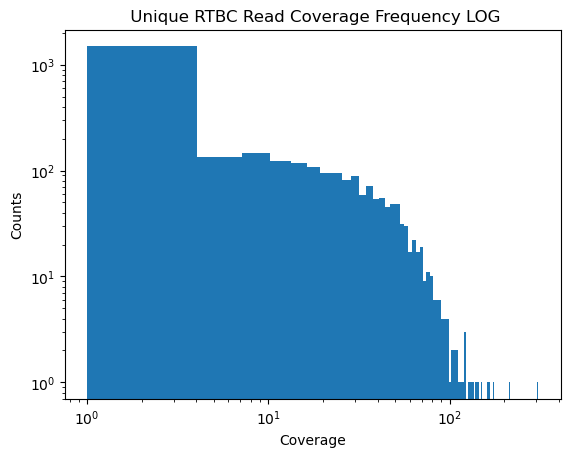

In [113]:
# plot ad bc coverage 
plt.hist(Rbcov['RTBC'], bins=100)
plt.title(f' Unique RTBC Read Coverage Frequency LOG')
plt.xlabel('Coverage')
plt.ylabel('Counts')
plt.xscale('log')
plt.yscale('log')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_RTBC_cov_log.{Fig_Format}'))
plt.show()

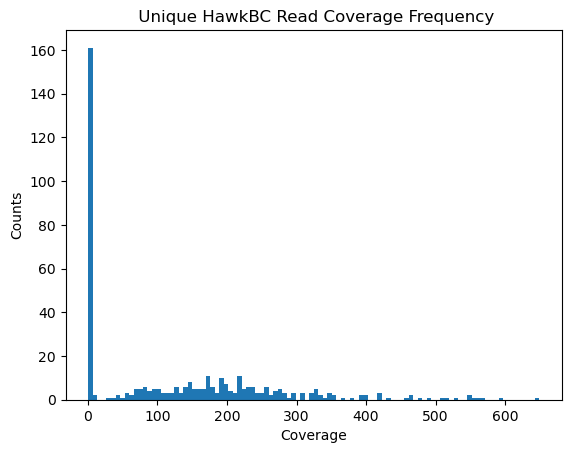

In [114]:
# plot ad bc coverage 
plt.hist(abcov['HawkBCs'], bins=100)
plt.title(f' Unique HawkBC Read Coverage Frequency')
plt.xlabel('Coverage')
plt.ylabel('Counts')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_HawkBC_cov.{Fig_Format}'))
plt.show()

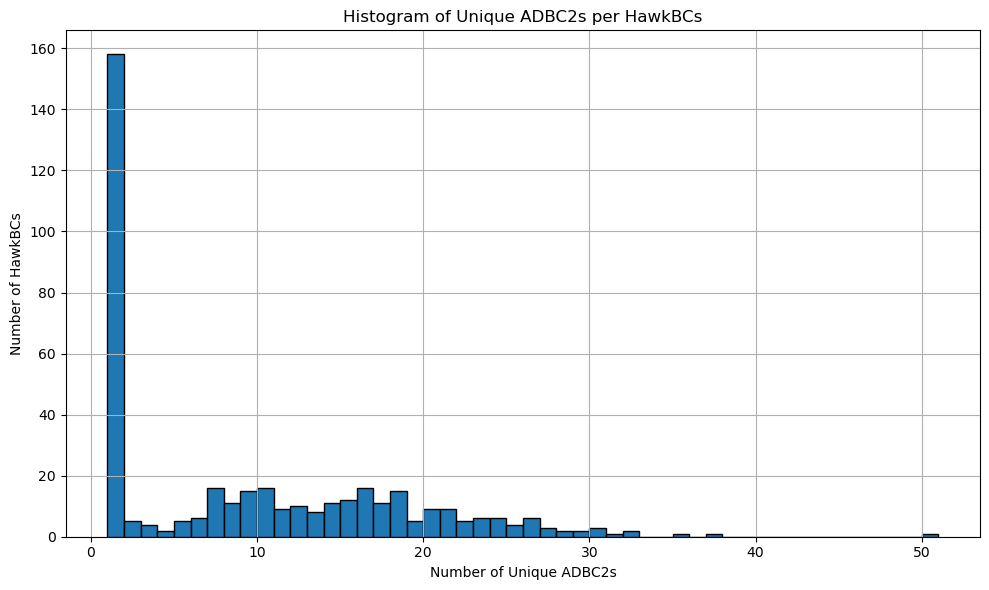

Min: 1
Max: 50
Median: 8.0
Mean: 9.41

Top 10 HawkBCs with highest number of unique ADBC2s:
HawkBCs
CATTCGTAC    50
CACAACTTC    37
ACCGGATGT    35
ATAAGCGCC    32
AGTCACAAC    32
ACCATTAGG    31
ACGACTGTG    30
AAGTCTCAC    30
CCGATCTAT    30
CCATATTCG    29
Name: ADBC2, dtype: int64


In [115]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by HawkBCs and count unique ADBC2s
adbc_per_hawkbc = map2.groupby('HawkBCs')['ADBC2'].nunique()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(adbc_per_hawkbc, bins=range(1, adbc_per_hawkbc.max() + 2), edgecolor='black')
plt.title('Histogram of Unique ADBC2s per HawkBCs')
plt.xlabel('Number of Unique ADBC2s')
plt.ylabel('Number of HawkBCs')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_uniADBCperHawkBC_cov.{Fig_Format}'))
plt.show()

# Print summary statistics
print(f"Min: {adbc_per_hawkbc.min()}")
print(f"Max: {adbc_per_hawkbc.max()}")
print(f"Median: {adbc_per_hawkbc.median()}")
print(f"Mean: {adbc_per_hawkbc.mean():.2f}")

# Print top 10 HawkBCs with highest unique ADBC2 counts
top10_adbc_per_hawkbc = adbc_per_hawkbc.sort_values(ascending=False).head(10)
print("\nTop 10 HawkBCs with highest number of unique ADBC2s:")
print(top10_adbc_per_hawkbc)

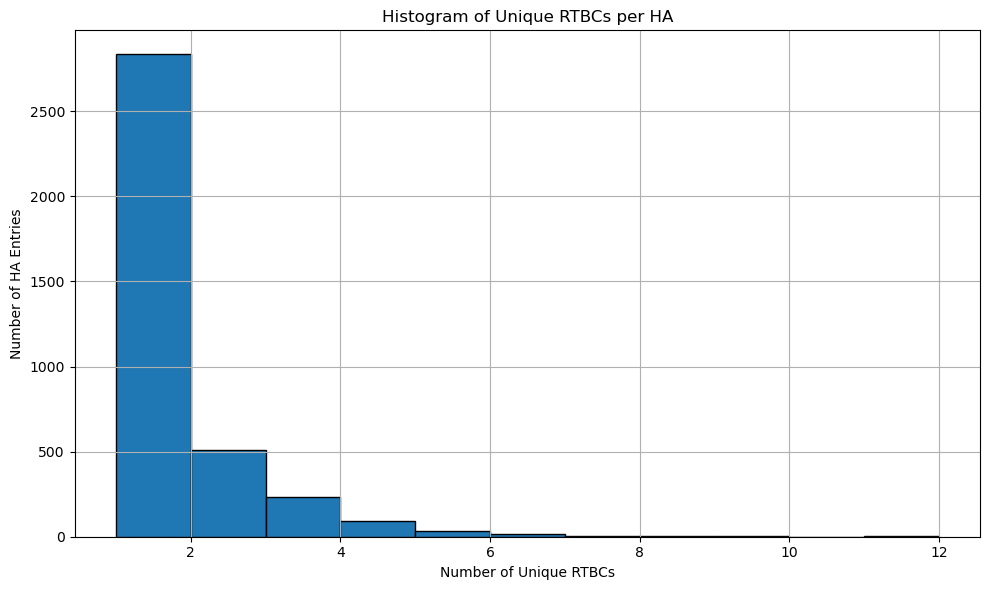

Min: 1
Max: 11
Median: 1.0
Mean: 1.41

Top 10 HA entries with highest number of unique RTBCs:
HA
CCATTCTGC-TATTAT    11
CCGATCTAT-GAAATT    11
CCAACACTA-ACGTTA     9
CACCGATTG-CCATAA     9
ACGGTTATG-GAAATG     8
AATACCACG-TTCAGG     8
ACGTCGAGA-CGTGAG     8
CCATCGGTT-GTACAA     8
CCATTCTGC-ATAAAT     7
ACTCCACAT-AGAATA     7
Name: RTBC, dtype: int64


In [116]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by HA and count unique RTBCs
rtbc_per_ha = map3.groupby('HA')['RTBC'].nunique()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(rtbc_per_ha, bins=range(1, rtbc_per_ha.max() + 2), edgecolor='black')
plt.title('Histogram of Unique RTBCs per HA')
plt.xlabel('Number of Unique RTBCs')
plt.ylabel('Number of HA Entries')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_uniRTBCperHA_cov.{Fig_Format}'))
plt.show()

# Print summary statistics
print(f"Min: {rtbc_per_ha.min()}")
print(f"Max: {rtbc_per_ha.max()}")
print(f"Median: {rtbc_per_ha.median()}")
print(f"Mean: {rtbc_per_ha.mean():.2f}")
# Print top 10 HA entries with highest unique RTBC counts
top10_rtbc_per_ha = rtbc_per_ha.sort_values(ascending=False).head(10)
print("\nTop 10 HA entries with highest number of unique RTBCs:")
print(top10_rtbc_per_ha)


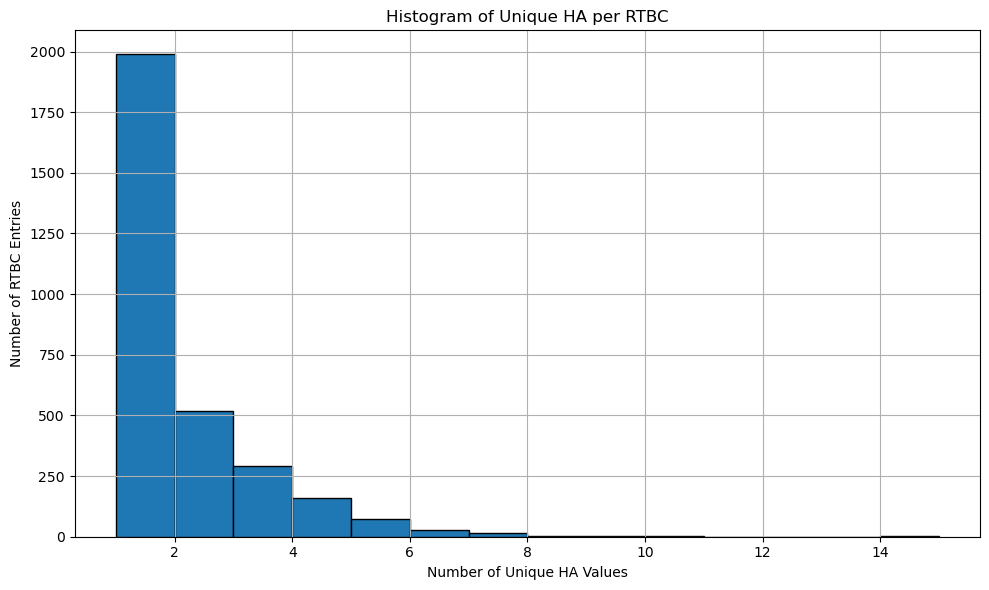

Min: 1
Max: 14
Median: 1.0
Mean: 1.71

Top 10 RTBCs with highest number of unique HA values:
RTBC
CAGCGTTTAACAAGCG    14
ACTATGCCAGATCTGA    10
CCTATTCAGAGTTCCA     9
TGTAAAATGGGGCTGG     9
GGTAACGTGAAATCCA     9
TCACTGCGCGAGTCCA     8
TAATTTCTGGAAAAGG     8
AGGTGATTTAAGTTAT     8
TTCCTTGGGCAGGCGG     8
CAGGAAATCCCTCTAT     8
Name: HA, dtype: int64


In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by RTBC and count unique HA values
ha_per_rtbc = map3.groupby('RTBC')['HA'].nunique()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(ha_per_rtbc, bins=range(1, ha_per_rtbc.max() + 2), edgecolor='black')
plt.title('Histogram of Unique HA per RTBC')
plt.xlabel('Number of Unique HA Values')
plt.ylabel('Number of RTBC Entries')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_uniHAperRTBC_cov.{Fig_Format}'))
plt.show()

# Print summary statistics
print(f"Min: {ha_per_rtbc.min()}")
print(f"Max: {ha_per_rtbc.max()}")
print(f"Median: {ha_per_rtbc.median()}")
print(f"Mean: {ha_per_rtbc.mean():.2f}")

# Print top 10 RTBCs with highest unique HA counts
top10_ha_per_rtbc = ha_per_rtbc.sort_values(ascending=False).head(10)
print("\nTop 10 RTBCs with highest number of unique HA values:")
print(top10_ha_per_rtbc)


In [118]:
# Unique Tile coverage
tcovA = map3['HA'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique Hawk+ADBC (HA) combos coverage')
summary_dict['Read Count'].append(tcovA.shape[0])

print (f'Unique Hawk+ADBC combos: {tcovA.shape[0]}')

Unique Hawk+ADBC combos: 3728


In [119]:
# Unique Tile coverage
tcovAr = map3['HAR'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique Hawk+ADBC+ RTBC (HAR) combos coverage')
summary_dict['Read Count'].append(tcovAr.shape[0])

print (f'Unique Hawk+ADBC+ RTBC combos: {tcovAr.shape[0]}')

Unique Hawk+ADBC+ RTBC combos: 5262


In [120]:
#make csv of map3
map3.to_csv(os.path.join(Output_Directory, f'{Lib_Name}_map3.csv'), index=False)
map3.to_excel(os.path.join(Output_Directory, f'{Lib_Name}_map3.xlsx'), index=False)

In [121]:
Threshold = 5
summary_dict['Category'].append(f'New Section')
summary_dict['Read Count'].append(f'Filter Map3 to keep rows that have {Threshold} minimum # of Reads per Cat')

In [122]:
#Filter to remove rows that appear less than threshold number of times

# Count how many times each Cat appears in map3
cat_counts = map3['Cat'].value_counts()

# Keep only Cats that occur >= Threshold times
valid_cats = cat_counts[cat_counts >= Threshold].index

# Filter map3 to keep only those rows
map3min = map3[map3['Cat'].isin(valid_cats)].copy()

print(f"Threshold: {Threshold}")
print(f"Original map3 rows: {len(map3)}")
print(f"Rows kept in map3min: {len(map3min)}")
print(f"Unique Cats kept: {map3min['Cat'].nunique()}")

Threshold: 5
Original map3 rows: 50751
Rows kept in map3min: 44250
Unique Cats kept: 1623


In [123]:
# Unique Tile coverage
tcovArd3 = map3min['Designed'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Map3 Filtered by read threshold shape unique tile ')
summary_dict['Read Count'].append(tcovArd3.shape[0])

print (f'Unique Tile combos Map3: {tcovArd3.shape[0]}')

Unique Tile combos Map3: 233


In [124]:
summary_dict['Category'].append(f'Map3 Filtered by read threshold shape')
summary_dict['Read Count'].append(map3min.shape[0])

In [125]:
summary_dict['Category'].append(f'Map3 Filtered by read threshold shape unique Cat')
summary_dict['Read Count'].append(map3min['Cat'].nunique())

In [126]:
summary_dict['Category'].append(f'Map3 Filtered by read threshold shape unique ADBC2')
summary_dict['Read Count'].append(map3min['ADBC2'].nunique())

In [127]:
summary_dict['Category'].append(f'Map3 Filtered by read threshold shape unique HawkBC')
summary_dict['Read Count'].append(map3min['HawkBCs'].nunique())

In [128]:
summary_dict['Category'].append(f'Map3 Filtered by read threshold shape unique HA')
summary_dict['Read Count'].append(map3min['HA'].nunique())

In [129]:
summary_dict['Category'].append(f'Map3 Filtered by read threshold shape unique HAR')
summary_dict['Read Count'].append(map3min['HAR'].nunique())

In [130]:
summary_dict['Category'].append(f'New Section')
summary_dict['Read Count'].append('Map3 filtered by read coverage and by removing RTBC that map to multiple HA')

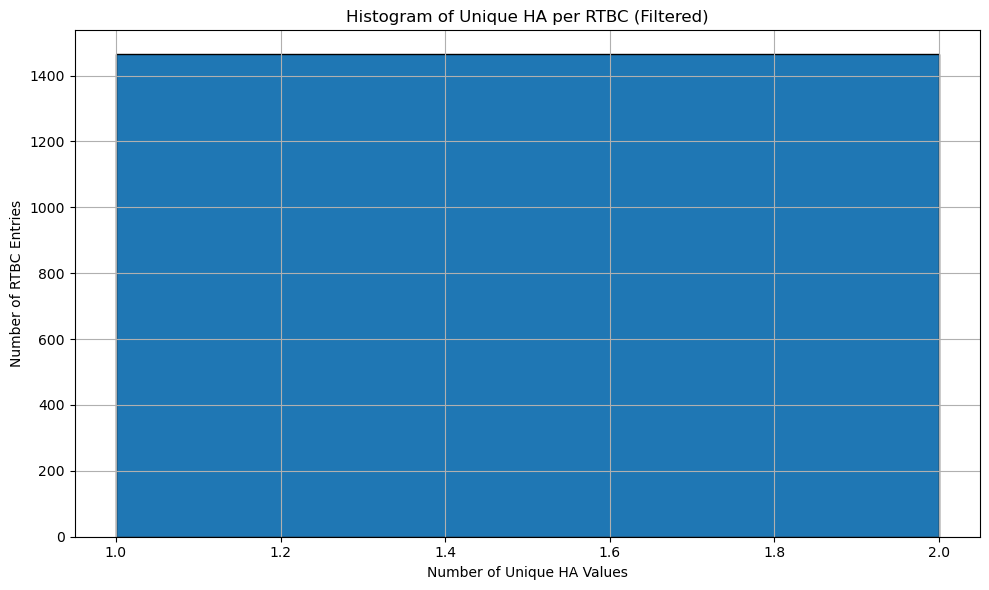

Min: 1
Max: 1
Median: 1.0
Mean: 1.00

Top 10 RTBCs with highest number of unique HA values (Filtered):
RTBC
AAAAAAAGAGAAGCAA    1
GGTATAGATAGCCCAA    1
GGTACCAACAAAAGTA    1
GGGTTGTTCAAAATCG    1
GGGGATGAGAAAGTTT    1
GGGCATGATTATTGCT    1
GGGCATAGGCTTGACA    1
GGGCAAGTGGAGATAC    1
GGGAGCGACTATTAGC    1
GGGACGAGACGCTGCA    1
Name: HA, dtype: int64


In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Group by RTBC and count unique HA values
ha_per_rtbc = map3min.groupby('RTBC')['HA'].nunique()

# Identify RTBCs with more than 1 unique HA
bad_rtbc = ha_per_rtbc[ha_per_rtbc > 1].index

# Identify all HAs associated with those RTBCs
bad_ha = map3min.loc[map3min['RTBC'].isin(bad_rtbc), 'HA'].unique()

# Remove rows with bad RTBCs or bad HAs
map3_filtered = map3min[~map3min['RTBC'].isin(bad_rtbc) & ~map3min['HA'].isin(bad_ha)]

# --- Recompute statistics on filtered dataset ---
ha_per_rtbc_filtered = map3_filtered.groupby('RTBC')['HA'].nunique()

#NOTE they should all equl 1 because the graph is made after filtering so that all RTBC should have a unique HA
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(ha_per_rtbc_filtered, bins=range(1, ha_per_rtbc_filtered.max() + 2), edgecolor='black')
plt.title('Histogram of Unique HA per RTBC (Filtered)')
plt.xlabel('Number of Unique HA Values')
plt.ylabel('Number of RTBC Entries')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_uniHAperRTBC_cov_filtered.{Fig_Format}'))
plt.show()

# Print summary statistics
print(f"Min: {ha_per_rtbc_filtered.min()}")
print(f"Max: {ha_per_rtbc_filtered.max()}")
print(f"Median: {ha_per_rtbc_filtered.median()}")
print(f"Mean: {ha_per_rtbc_filtered.mean():.2f}")

# Print top 10 RTBCs with highest unique HA counts
top10_ha_per_rtbc = ha_per_rtbc_filtered.sort_values(ascending=False).head(10)
print("\nTop 10 RTBCs with highest number of unique HA values (Filtered):")
print(top10_ha_per_rtbc)

In [132]:
# Mask for removed rows (bad RTBCs or bad HAs)
removed_mask = map3min['RTBC'].isin(bad_rtbc) | map3min['HA'].isin(bad_ha)

# DataFrame of removed rows
removed_rows = map3min[removed_mask].copy()

# Optional: save removed rows to CSV for inspection
removed_fp = os.path.join(Output_Directory, f'{Lib_Name}_removed_badRTBC_HA.csv')
removed_rows.to_csv(removed_fp, index=False)

print(f"Removed rows saved to: {removed_fp}")
print(f"Number of removed rows: {len(removed_rows)}")
print(removed_rows.head(10))  # peek at first 10


Removed rows saved to: New_filter_order_Tile_ONLY_All3_bcs_TL4_i35_S1_adbc_vs hawkbc_9_4_2025_Maps_and_Graphs\New_filter_order_Tile_ONLY_All3_bcs_TL4_i35_S1_adbc_vs hawkbc_9_4_2025_removed_badRTBC_HA.csv
Number of removed rows: 3269
      ADBC2    HawkBCs              RTBC  \
3    ACCAGA  ACATTGCCG  AGAATTTGTTCGTCTG   
58   ACCAGA  ACATTGCCG  AGAATTTGTTCGTCTG   
114  GACGTC  ATCTGGTAG  AATAGTACACGTTATG   
116  ATAATG  CCAGAAGAT  CAAATAGGTAGTAAGA   
133  TAAACG  CCAAGGTGT  GCGAGGAATTTCACGC   
145  TGCTAA  AGTTCTAGG  TTCACTAAAAACTACG   
146  AGGTAG  AGTCCTCCT  TTCAATTCAAAAGAAG   
160  AAAACC  AAGCTGCGA  AGTAATATAAGGGTAA   
176  AAAATG  CATTCGTAC  TTCGGTTTACTAGACG   
201  CAATAG  CAGACAGCA  GGTAAGAACTAATTGA   

                                              Designed  \
3    GCCCAGGACCTGGCCGCCGCCACCTTCCAGAGCAGCGGCGCCTACT...   
58   GCCCAGGACCTGGCCGCCGCCACCTTCCAGAGCAGCGGCGCCTACT...   
114  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCCAGTTCA...   
116  GAGGAGCCTCAGAGCGATCCCAGCGTGGAGCCTCCTCTGAGCCAG

In [152]:
# Group removed_rows by Cat and count how many times each appears
removed_cats = (
    removed_rows.groupby('Cat')
    .size()
    .reset_index(name='Cat_Count')
)

# Optional: save this summary
removed_cats_fp = os.path.join(Output_Directory, f'{Lib_Name}_removed_CatCounts.csv')
removed_cats.to_csv(removed_cats_fp, index=False)
removed_cats_fpp = os.path.join(Output_Directory, f'{Lib_Name}_removed_CatCounts.xlsx')
removed_cats.to_excel(removed_cats_fpp, index=False)

print(f"Removed Cat summary saved to: {removed_cats_fp}")
print(removed_cats.head(10))  # preview first 10
print(len(removed_cats))


Removed Cat summary saved to: New_filter_order_Tile_ONLY_All3_bcs_TL4_i35_S1_adbc_vs hawkbc_9_4_2025_Maps_and_Graphs\New_filter_order_Tile_ONLY_All3_bcs_TL4_i35_S1_adbc_vs hawkbc_9_4_2025_removed_CatCounts.csv
                                                 Cat  Cat_Count
0  AACAGAGTC-AATGTC-AATTATTTCCTACATT-GCCCAGGACCTG...         38
1  AACAGAGTC-TATCAA-AATTATTTCCTACATT-GCCCAGGACCTG...         14
2  AACGTCACT-AATAAT-ATCCCATCAAAAAGAC-TTCGCCGACGCC...          9
3  AACGTCACT-TTAGAT-ATCCCATCAAAAAGAC-TTCGCCGACGCC...         40
4  AACTTGACC-GATCCC-AGAATTTGTTCGTCTG-GCCCAGGACCTG...          5
5  AAGACATCG-ACCATA-TCACACGAAAAGTATA-GCCCAGGACCTG...         10
6  AAGATTCCG-ATCCTT-TCTGTGAGGATTATTT-GCCCAGGACCTG...         22
7  AAGATTCCG-GCAATC-TCTGTGAGGATTATTT-GCCCAGGACCTG...          9
8  AAGCTGCGA-AAAACC-AGTAATATAAGGGTAA-GCCCAGGACCTG...         34
9  AAGCTGCGA-ACTGGG-AGTAATATAAGGGTAA-GCCCAGGACCTG...          5
156


Sorted removed Cat summary saved to: New_filter_order_Tile_ONLY_All3_bcs_TL4_i35_S1_adbc_vs hawkbc_9_4_2025_Maps_and_Graphs\New_filter_order_Tile_ONLY_All3_bcs_TL4_i35_S1_adbc_vs hawkbc_9_4_2025_removed_CatCounts_sorted.csv
                                                   Cat  Cat_Count
149  CCGATCTAT-GAGATA-TTTTGCTATCAATATG-ACCGACTTCATC...         97
152  CCGTGATAC-GAAGGA-ACTATGCCAGATCTGA-ACCGACGCCATC...         96
141  CCATATTCG-ATTCTA-TGAATCAAGGGTAGGG-GACTCTCCCGGA...         78
139  CCAGCTAAT-ATCACA-GGGAAGAAAGCTACAC-AGCACCGCTCCT...         65
153  CCGTGATAC-GAATAC-ACTATGCCAGATCTGA-ACCGACGCCATC...         58
128  CATTCGTAC-TTGTTG-TACGTAGGCTTAAGTA-ACCGACTTCATC...         56
94   ATCTGGTAG-TCCGTG-TAACAGGGTTAGGTCT-GCCCAGGACCTG...         54
41   ACGTCGAGA-CAGGAA-ACCACAAGCAAGAAGT-GCCCAGGACCTG...         46
102  CACAAGGAC-GTACAG-AATAAAGATAAAACCA-GCCCAGGACCTG...         46
91   ATCTGGTAG-GAAACG-TAACAGGGTTAGGTCT-GCCCAGGACCTG...         46


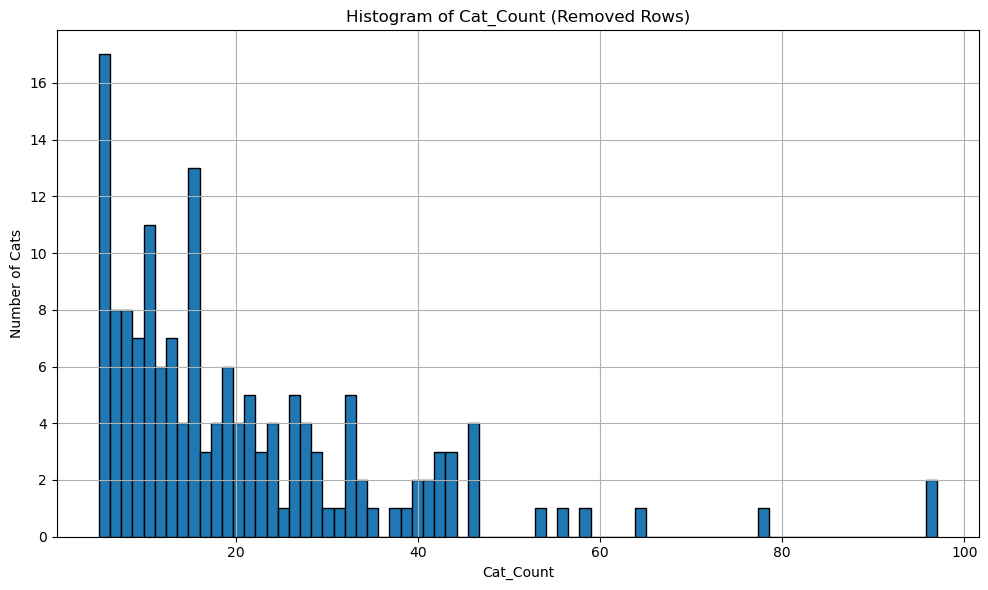

In [134]:
# --- Sort removed_cats by largest Cat_Count ---
removed_cats_sorted = removed_cats.sort_values(by='Cat_Count', ascending=False)

# Save sorted version
removed_cats_sorted_fp = os.path.join(Output_Directory, f'{Lib_Name}_removed_CatCounts_sorted.csv')
removed_cats_sorted.to_csv(removed_cats_sorted_fp, index=False)

print(f"Sorted removed Cat summary saved to: {removed_cats_sorted_fp}")
print(removed_cats_sorted.head(10))  # preview top 10

# --- Plot histogram of Cat_Count ---
plt.figure(figsize=(10, 6))
plt.hist(removed_cats_sorted['Cat_Count'], bins=75, edgecolor='black')
plt.title('Histogram of Cat_Count (Removed Rows)')
plt.xlabel('Cat_Count')
plt.ylabel('Number of Cats')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_removed_CatCount_hist.{Fig_Format}'))
plt.show()


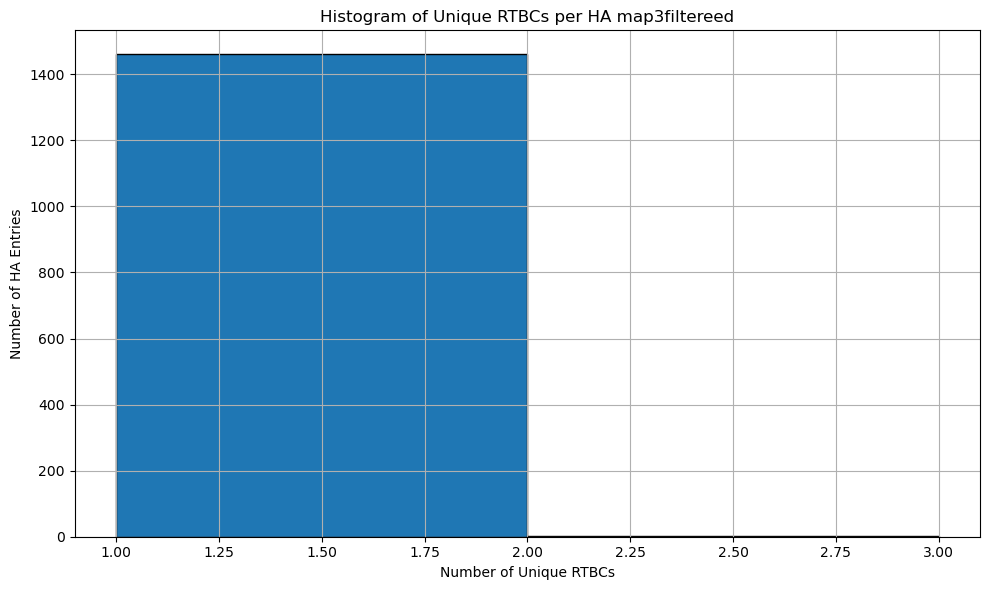

Min: 1
Max: 2
Median: 1.0
Mean: 1.00


In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by HA and count unique RTBCs
rtbc_per_hat = map3_filtered.groupby('HA')['RTBC'].nunique()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(rtbc_per_hat, bins=range(1, rtbc_per_hat.max() + 2), edgecolor='black')
plt.title('Histogram of Unique RTBCs per HA map3filtereed')
plt.xlabel('Number of Unique RTBCs')
plt.ylabel('Number of HA Entries')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_uniRTBCperHA_cov_map3filtered.{Fig_Format}'))
plt.show()

# Print summary statistics
print(f"Min: {rtbc_per_hat.min()}")
print(f"Max: {rtbc_per_hat.max()}")
print(f"Median: {rtbc_per_hat.median()}")
print(f"Mean: {rtbc_per_hat.mean():.2f}")
# Print top 10 HA entries with highest unique RTBC counts
#top10_rtbc_per_ha = rtbc_per_ha.sort_values(ascending=False).head(10)
#print("\nTop 10 HA entries with highest number of unique RTBCs:")
#print(top10_rtbc_per_ha)


In [136]:
import pandas as pd

# Step 1: Count how many times each Cat value appears
cat_countss = map3_filtered['Cat'].value_counts()

# Step 2: Drop duplicate Cat rows, keeping the first occurrence
map4 = map3_filtered.drop_duplicates(subset='Cat').copy()

# Step 3: Add the Cat_Coverage column
map4['Cat_Counts'] = map4['Cat'].map(cat_countss)
map4

ADBC2    HawkBCs              RTBC  \
0      CGATCC  CCACATCAT  GTAAAGTAGTAAATAC   
1      ACAGAC  ACAAGCGTT  CGATAATTTAGAATGT   
2      GAATTG  AACCTACGC  TAGCGTATTGAGCGAA   
4      GCTTGC  AAGGATCTG  TCTAATAGTGGATCGT   
5      TTGAGT  CCATCGGTT  ACATGTCATTTTAATC   
...       ...        ...               ...   
22769  ACAAGC  ATCCGCTGT  CAACCTAAAAATTTGG   
23177  AGTGAA  ACCAAGATC  TCCTCTCGAATTCATA   
23454  ATTTTT  AGCAGACTT  CAGACGAATAGCGAAT   
28420  GTCACT  ACTCGTCGT  ACCATCTATGTGCGAA   
28659  TCTTCT  ATAAGCGCC  CTGCATATCGACAATA   

                                                Designed  \
0      AGCATGGACGAGAGCGGCCTGCCTCAGCTGACCAGCTACGACTGCG...   
1      GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
2      GCCCAGGACCTGAGCAGCCTGACCTTCCAGGCCGGCATTCCCTTCA...   
4      GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
5      GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...   
...                                                  ...   
22769  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCAAGTTCA...   
23177  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
23454  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATCCAGTACA...   
28420  GCCCAGGACCTGGCCGCCGCCACCTTCTTCGCCGGCATTCCCTTCA...   
28659  GCTCCCGACCTGGCCGCCGCCACCTTTCCCGCCGGCATTCCCTTCA...   

                                                     Cat                HA  \
0      CCACATCAT-CGATCC-GTAAAGTAGTAAATAC-AGCATGGACGAG...  CCACATCAT-CGATCC   
1      ACAAGCGTT-ACAGAC-CGATAATTTAGAATGT-GCCCAGGACCTG...  ACAAGCGTT-ACAGAC   
2      AACCTACGC-GAATTG-TAGCGTATTGAGCGAA-GCCCAGGACCTG...  AACCTACGC-GAATTG   
4      AAGGATCTG-GCTTGC-TCTAATAGTGGATCGT-GCCCAGGACCTG...  AAGGATCTG-GCTTGC   
5      CCATCGGTT-TTGAGT-ACATGTCATTTTAATC-GACTCTCCCGGA...  CCATCGGTT-TTGAGT   
...                                                  ...               ...   
22769  ATCCGCTGT-ACAAGC-CAACCTAAAAATTTGG-GCCCAGGACCTG...  ATCCGCTGT-ACAAGC   
23177  ACCAAGATC-AGTGAA-TCCTCTCGAATTCATA-GCCCAGGACCTG...  ACCAAGATC-AGTGAA   
23454  AGCAGACTT-ATTTTT-CAGACGAATAGCGAAT-GCCCAGGACCTG...  AGCAGACTT-ATTTTT   
28420  ACTCGTCGT-GTCACT-ACCATCTATGTGCGAA-GCCCAGGACCTG...  ACTCGTCGT-GTCACT   
28659  ATAAGCGCC-TCTTCT-CTGCATATCGACAATA-GCTCCCGACCTG...  ATAAGCGCC-TCTTCT   

                                     HAR  Cat_Counts  
0      CCACATCAT-CGATCC-GTAAAGTAGTAAATAC          84  
1      ACAAGCGTT-ACAGAC-CGATAATTTAGAATGT          37  
2      AACCTACGC-GAATTG-TAGCGTATTGAGCGAA          51  
4      AAGGATCTG-GCTTGC-TCTAATAGTGGATCGT           8  
5      CCATCGGTT-TTGAGT-ACATGTCATTTTAATC          64  
...                                  ...         ...  
22769  ATCCGCTGT-ACAAGC-CAACCTAAAAATTTGG           6  
23177  ACCAAGATC-AGTGAA-TCCTCTCGAATTCATA           5  
23454  AGCAGACTT-ATTTTT-CAGACGAATAGCGAAT          10  
28420  ACTCGTCGT-GTCACT-ACCATCTATGTGCGAA           8  
28659  ATAAGCGCC-TCTTCT-CTGCATATCGACAATA           8  

[1467 rows x 8 columns]

In [137]:
map4 = map4.sort_values(by='Cat_Counts', ascending=False)
map4

ADBC2    HawkBCs              RTBC  \
52    CCATAA  CACCGATTG  CAGCGTTTAACAAGCG   
376   GTCAGC  CCATTAACG  TGTAAAATGGGGCTGG   
345   GTACAA  CCATCGGTT  TTGCAGAATAGCTGCA   
225   AGTAAA  CCGCAGTTA  ACATATTCTTGAAGGA   
393   ATTATT  CCGGAGAAT  CCGTTTCCATAAGTTT   
...      ...        ...               ...   
1208  TTAGGA  ACATGGTCA  ACTAATGAGTGATAAA   
9645  CGGATT  ACGCAATCC  TGTAGGCCCGATAGCT   
2664  GTTACT  CCGAACCAA  GTCGAAAAAATTGTAT   
9380  AACAAG  ACATACTCC  TCTTCAAAATAAATTT   
4219  AAGCCC  CAGATCGTT  CGGAAATTCAAAAATC   

                                               Designed  \
52    GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...   
376   GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...   
345   GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...   
225   ACCGACTTCATCGACGAGGAGGTGATCATGAGCATCGTGATCGAGA...   
393   ACCGACTTCATCGACGAGGAGGTGGCCATGAGCGCCGTGATCGAGA...   
...                                                 ...   
1208  GCCTTCGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
9645  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
2664  CCTCCCACCGACGTGAGCGCCGGCGACGAGGCCCACGCCGACGGCG...   
9380  GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   
4219  GCCCAGGACGCCGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...   

                                                    Cat                HA  \
52    CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...  CACCGATTG-CCATAA   
376   CCATTAACG-GTCAGC-TGTAAAATGGGGCTGG-GACTCTCCCGGA...  CCATTAACG-GTCAGC   
345   CCATCGGTT-GTACAA-TTGCAGAATAGCTGCA-GACTCTCCCGGA...  CCATCGGTT-GTACAA   
225   CCGCAGTTA-AGTAAA-ACATATTCTTGAAGGA-ACCGACTTCATC...  CCGCAGTTA-AGTAAA   
393   CCGGAGAAT-ATTATT-CCGTTTCCATAAGTTT-ACCGACTTCATC...  CCGGAGAAT-ATTATT   
...                                                 ...               ...   
1208  ACATGGTCA-TTAGGA-ACTAATGAGTGATAAA-GCCTTCGACCTG...  ACATGGTCA-TTAGGA   
9645  ACGCAATCC-CGGATT-TGTAGGCCCGATAGCT-GCCCAGGACCTG...  ACGCAATCC-CGGATT   
2664  CCGAACCAA-GTTACT-GTCGAAAAAATTGTAT-CCTCCCACCGAC...  CCGAACCAA-GTTACT   
9380  ACATACTCC-AACAAG-TCTTCAAAATAAATTT-GCCCAGGACCTG...  ACATACTCC-AACAAG   
4219  CAGATCGTT-AAGCCC-CGGAAATTCAAAAATC-GCCCAGGACGCC...  CAGATCGTT-AAGCCC   

                                    HAR  Cat_Counts  
52    CACCGATTG-CCATAA-CAGCGTTTAACAAGCG         293  
376   CCATTAACG-GTCAGC-TGTAAAATGGGGCTGG         202  
345   CCATCGGTT-GTACAA-TTGCAGAATAGCTGCA         163  
225   CCGCAGTTA-AGTAAA-ACATATTCTTGAAGGA         159  
393   CCGGAGAAT-ATTATT-CCGTTTCCATAAGTTT         147  
...                                 ...         ...  
1208  ACATGGTCA-TTAGGA-ACTAATGAGTGATAAA           5  
9645  ACGCAATCC-CGGATT-TGTAGGCCCGATAGCT           5  
2664  CCGAACCAA-GTTACT-GTCGAAAAAATTGTAT           5  
9380  ACATACTCC-AACAAG-TCTTCAAAATAAATTT           5  
4219  CAGATCGTT-AAGCCC-CGGAAATTCAAAAATC           5  

[1467 rows x 8 columns]

In [138]:
summary_dict['Category'].append(f'Map3 read coverage >= {Threshold} and no RTBC that map to multiple HA')
summary_dict['Read Count'].append(map3_filtered.shape[0])

summary_dict['Category'].append(f'map4 shape unique Cat')
summary_dict['Read Count'].append(map4.shape[0])


In [139]:


# # Step 1: Calculate the number of rows that represent the top 10%
# top_10_percent_count = int(len(map4) * 0.10)

# # Step 2: Sort map4 by Cat_Coverage in descending order (if not already sorted)
# map4_sorted = map4.sort_values(by='Cat_Coverage', ascending=False)

# # Step 3: Slice the top 10% rows
# top_10_df = map4_sorted.head(top_10_percent_count).copy()

# # Step 4: Export to CSV and Excel
# top_10_df.to_csv('top_10_percent_map4.csv', index=False)
# top_10_df.to_excel('top_10_percent_map4.xlsx', index=False)


In [140]:
map4.to_excel(os.path.join(Output_Directory,f'{Lib_Name}_map4_unique_Cat_min_{Threshold}_reads.xlsx'), index=False)
map4.to_csv(os.path.join(Output_Directory,f'{Lib_Name}_map4_unique_Cat_min_{Threshold}_reads.csv'), index=False)

In [141]:
# Unique Tile coverage
tcovArr = map4['HAR'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique Hawk+ADBC+ RTBC combos coverage Map4')
summary_dict['Read Count'].append(tcovArr.shape[0])

print (f'Unique Hawk+ADBC+ RTBC combos map4: {tcovArr.shape[0]}')

Unique Hawk+ADBC+ RTBC combos map4: 1464


In [142]:
# Unique Tile coverage
tcovAr = map4['HA'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique Hawk+ADBC combos coverage Map4')
summary_dict['Read Count'].append(tcovAr.shape[0])

print (f'Unique Hawk+ADBC combos Map4: {tcovAr.shape[0]}')

Unique Hawk+ADBC combos Map4: 1462


In [143]:
# Unique Tile coverage
tcovArd = map4['Designed'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique Tile coverage Map4')
summary_dict['Read Count'].append(tcovArd.shape[0])

print (f'Unique Tile combos Map4: {tcovArd.shape[0]}')

Unique Tile combos Map4: 233


In [144]:
#Unique ad bc coverage
abcovt = map4['HawkBCs'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique HawkBC map4')
summary_dict['Read Count'].append(abcovt.shape[0])

print(f'Unique HawkBCs: {abcovt.shape[0]}') # number unique ad bcs

Unique HawkBCs: 236


In [145]:
#Unique ad bc coverage
abcovta = map4['ADBC2'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique ADBC2 map4')
summary_dict['Read Count'].append(abcovta.shape[0])

print(f'Unique ADBC2: {abcovta.shape[0]}') # number unique ad bcs

Unique ADBC2: 1143


In [146]:
#Unique ad bc coverage
abcovtav = map4['RTBC'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique RTBC map4')
summary_dict['Read Count'].append(abcovtav.shape[0])

print(f'Unique RTBC: {abcovtav.shape[0]}') # number unique ad bcs

Unique RTBC: 1464


In [147]:
#Unique ad bc coverage
abcovtavc = map4['Cat'].value_counts().to_frame().reset_index()

summary_dict['Category'].append(f'Unique Cat map4')
summary_dict['Read Count'].append(abcovtavc.shape[0])

print(f'Unique Cat: {abcovtavc.shape[0]}') # number unique ad bcs

Unique Cat: 1467


In [149]:
tbcov4 = map3_filtered['Cat'].value_counts().to_frame().reset_index()


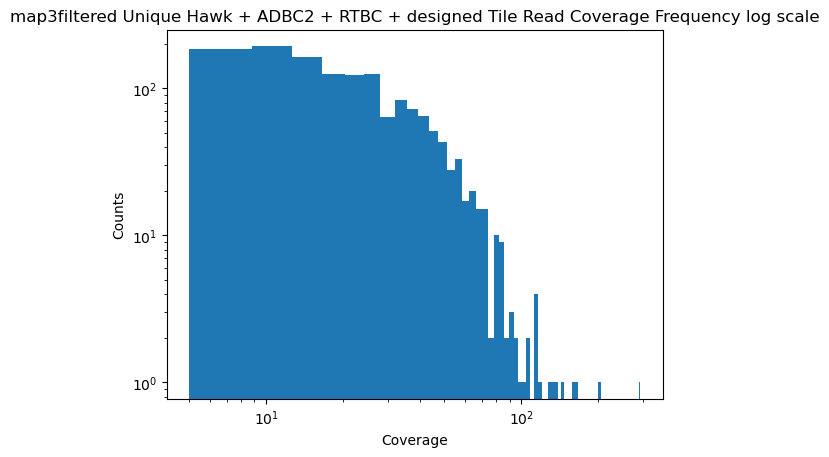

In [150]:
# plot tb coverage on histogram
plt.figure()
plt.title(f'map3filtered Unique Hawk + ADBC2 + RTBC + designed Tile Read Coverage Frequency log scale')
plt.hist(tbcov4['Cat'],  bins=75)
plt.xlabel('Coverage')
plt.ylabel('Counts')
plt.xscale('log')
plt.yscale('log')
plt.savefig(os.path.join(Output_Directory, f'{Lib_Name}_HAR_map3filtered_log_cov.{Fig_Format}'))
plt.show()

In [151]:
#create summary table
summary_dict_df = pd.DataFrame.from_dict(summary_dict)
summary_dict_df.to_csv(os.path.join(Output_Directory, f'{Lib_Name}_LUT_Summary.csv'), index=False)
summary_dict_df.to_excel(os.path.join(Output_Directory,f'{Lib_Name}_LUT_Summary.xlsx'), index=False)